In [1]:
import os
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
                         # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.seasonal import seasonal_decompose

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import seaborn as sns
sns.set_style(
    style='whitegrid', 
    rc={'axes.facecolor': '.95', 'grid.color': '.95'}
)

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.random.set_seed(2)

from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Flatten, GRU

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

os.environ['PYTHONHASHSEED'] = str(2)
np.random.seed(2)

In [2]:
df = pd.read_csv('output.csv')
df.head()

,time,Toffice_reference,humidity,detected_motions,occupancy,office_CO2_concentratio,door,label
0,2015-01-06 15:00:00,19.45,42.0,0,0.0,469.265967,1.00000,1.128000
1,2015-01-06 15:05:00,19.45,42.0,0,0.0,448.187067,1.00000,0.622000
2,2015-01-06 15:10:00,19.45,42.0,0,0.0,454.433067,1.00000,0.634000
3,2015-01-06 15:15:00,19.45,42.0,1,0.0,457.387200,0.39944,0.285733
4,2015-01-06 15:20:00,19.45,42.0,0,0.0,444.462833,0.00000,0.094000


In [3]:
df.tail()

,time,Toffice_reference,humidity,detected_motions,occupancy,office_CO2_concentratio,door,label
102925,2015-12-30 00:05:00,18.35,33.0,0,0.0,430.0,0.0,0.01
102926,2015-12-30 00:10:00,18.35,33.0,0,0.0,430.0,0.0,0.01
102927,2015-12-30 00:15:00,18.35,33.0,0,0.0,430.0,0.0,0.01
102928,2015-12-30 00:20:00,18.35,33.0,0,0.0,430.0,0.0,0.01
102929,2015-12-30 00:25:00,18.35,33.0,0,0.0,430.0,0.0,0.01


In [4]:
#Find missing data!
pd.date_range('2015-01-06 15:00:00', '2015-12-30 00:25:00', freq='5Min').difference(pd.to_datetime(df["time"]))

DatetimeIndex(['2015-03-29 02:00:00', '2015-03-29 02:05:00',
               '2015-03-29 02:10:00', '2015-03-29 02:15:00',
               '2015-03-29 02:20:00', '2015-03-29 02:25:00',
               '2015-03-29 02:30:00', '2015-03-29 02:35:00',
               '2015-03-29 02:40:00', '2015-03-29 02:45:00',
               '2015-03-29 02:50:00', '2015-03-29 02:55:00'],
              dtype='datetime64[ns]', freq=None)

In [5]:
df.isna().sum()

time                       0
Toffice_reference          0
humidity                   0
detected_motions           0
occupancy                  0
office_CO2_concentratio    0
door                       0
label                      0
dtype: int64

In [6]:
df["time"]= pd.to_datetime(df["time"])
df.set_index(["time"], inplace=True)
df.head()

,Toffice_reference,humidity,detected_motions,occupancy,office_CO2_concentratio,door,label
time,,,,,,,
2015-01-06 15:00:00,19.45,42.0,0,0.0,469.265967,1.00000,1.128000
2015-01-06 15:05:00,19.45,42.0,0,0.0,448.187067,1.00000,0.622000
2015-01-06 15:10:00,19.45,42.0,0,0.0,454.433067,1.00000,0.634000
2015-01-06 15:15:00,19.45,42.0,1,0.0,457.387200,0.39944,0.285733
2015-01-06 15:20:00,19.45,42.0,0,0.0,444.462833,0.00000,0.094000


In [7]:
df.drop(['Toffice_reference', 'humidity', 'detected_motions', 'occupancy', 'office_CO2_concentratio','door'], axis=1, inplace=True)

In [8]:
df.head()

,label
time,
2015-01-06 15:00:00,1.128000
2015-01-06 15:05:00,0.622000
2015-01-06 15:10:00,0.634000
2015-01-06 15:15:00,0.285733
2015-01-06 15:20:00,0.094000


In [9]:
df[df['label']<0] = 0

In [10]:
df[df['label']<0]

,label
time,


In [11]:
data_per_5min = df
data_per_Hour = df.resample('H').sum()
data_per_5min.shape, data_per_Hour.shape

((102930, 1), (8578, 1))

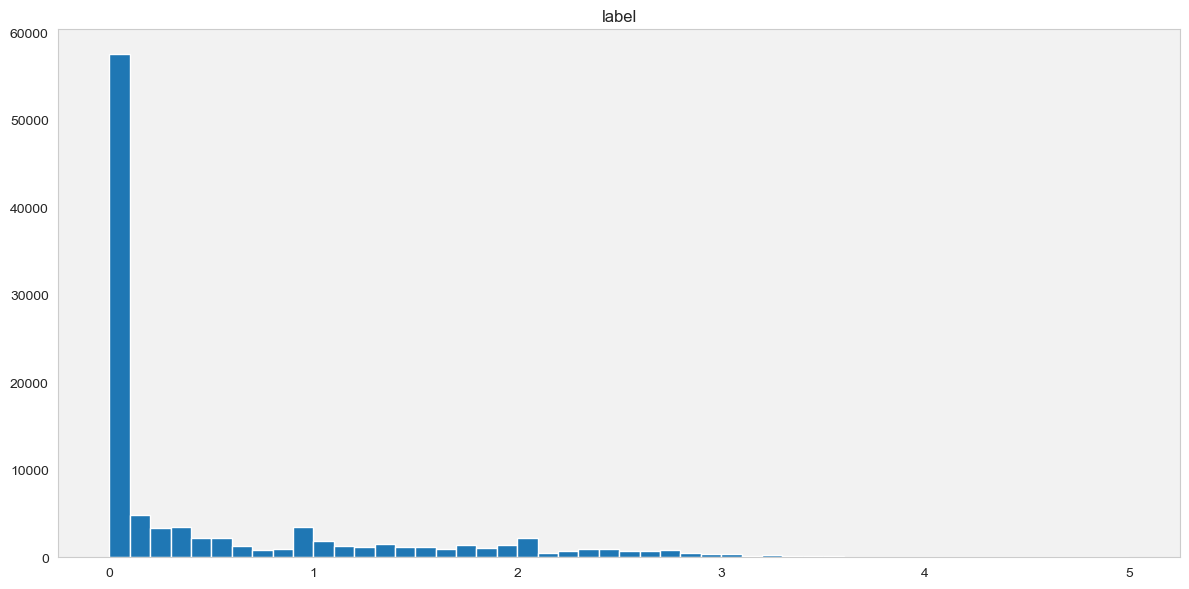

In [12]:
df.hist(bins=50)
plt.tight_layout()

<AxesSubplot:ylabel='label'>

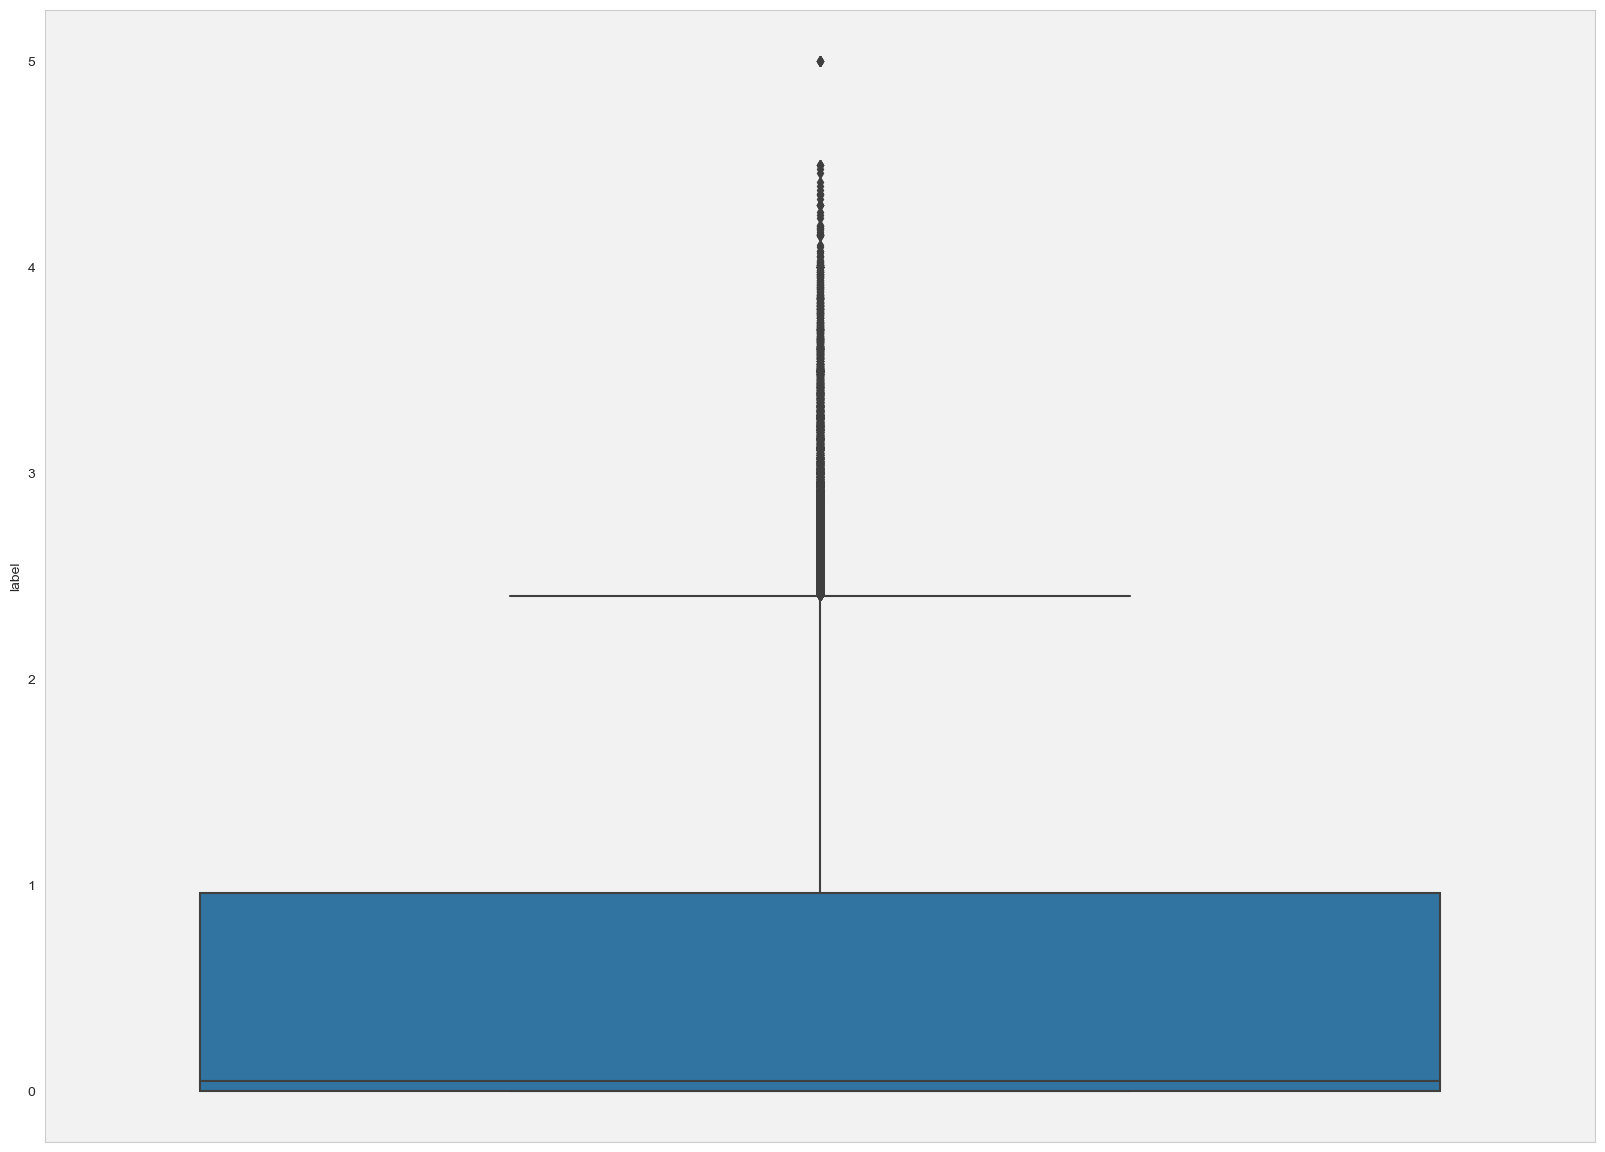

In [13]:
fig = plt.figure(figsize=(20, 15))
sns.boxplot(data=df, y='label')



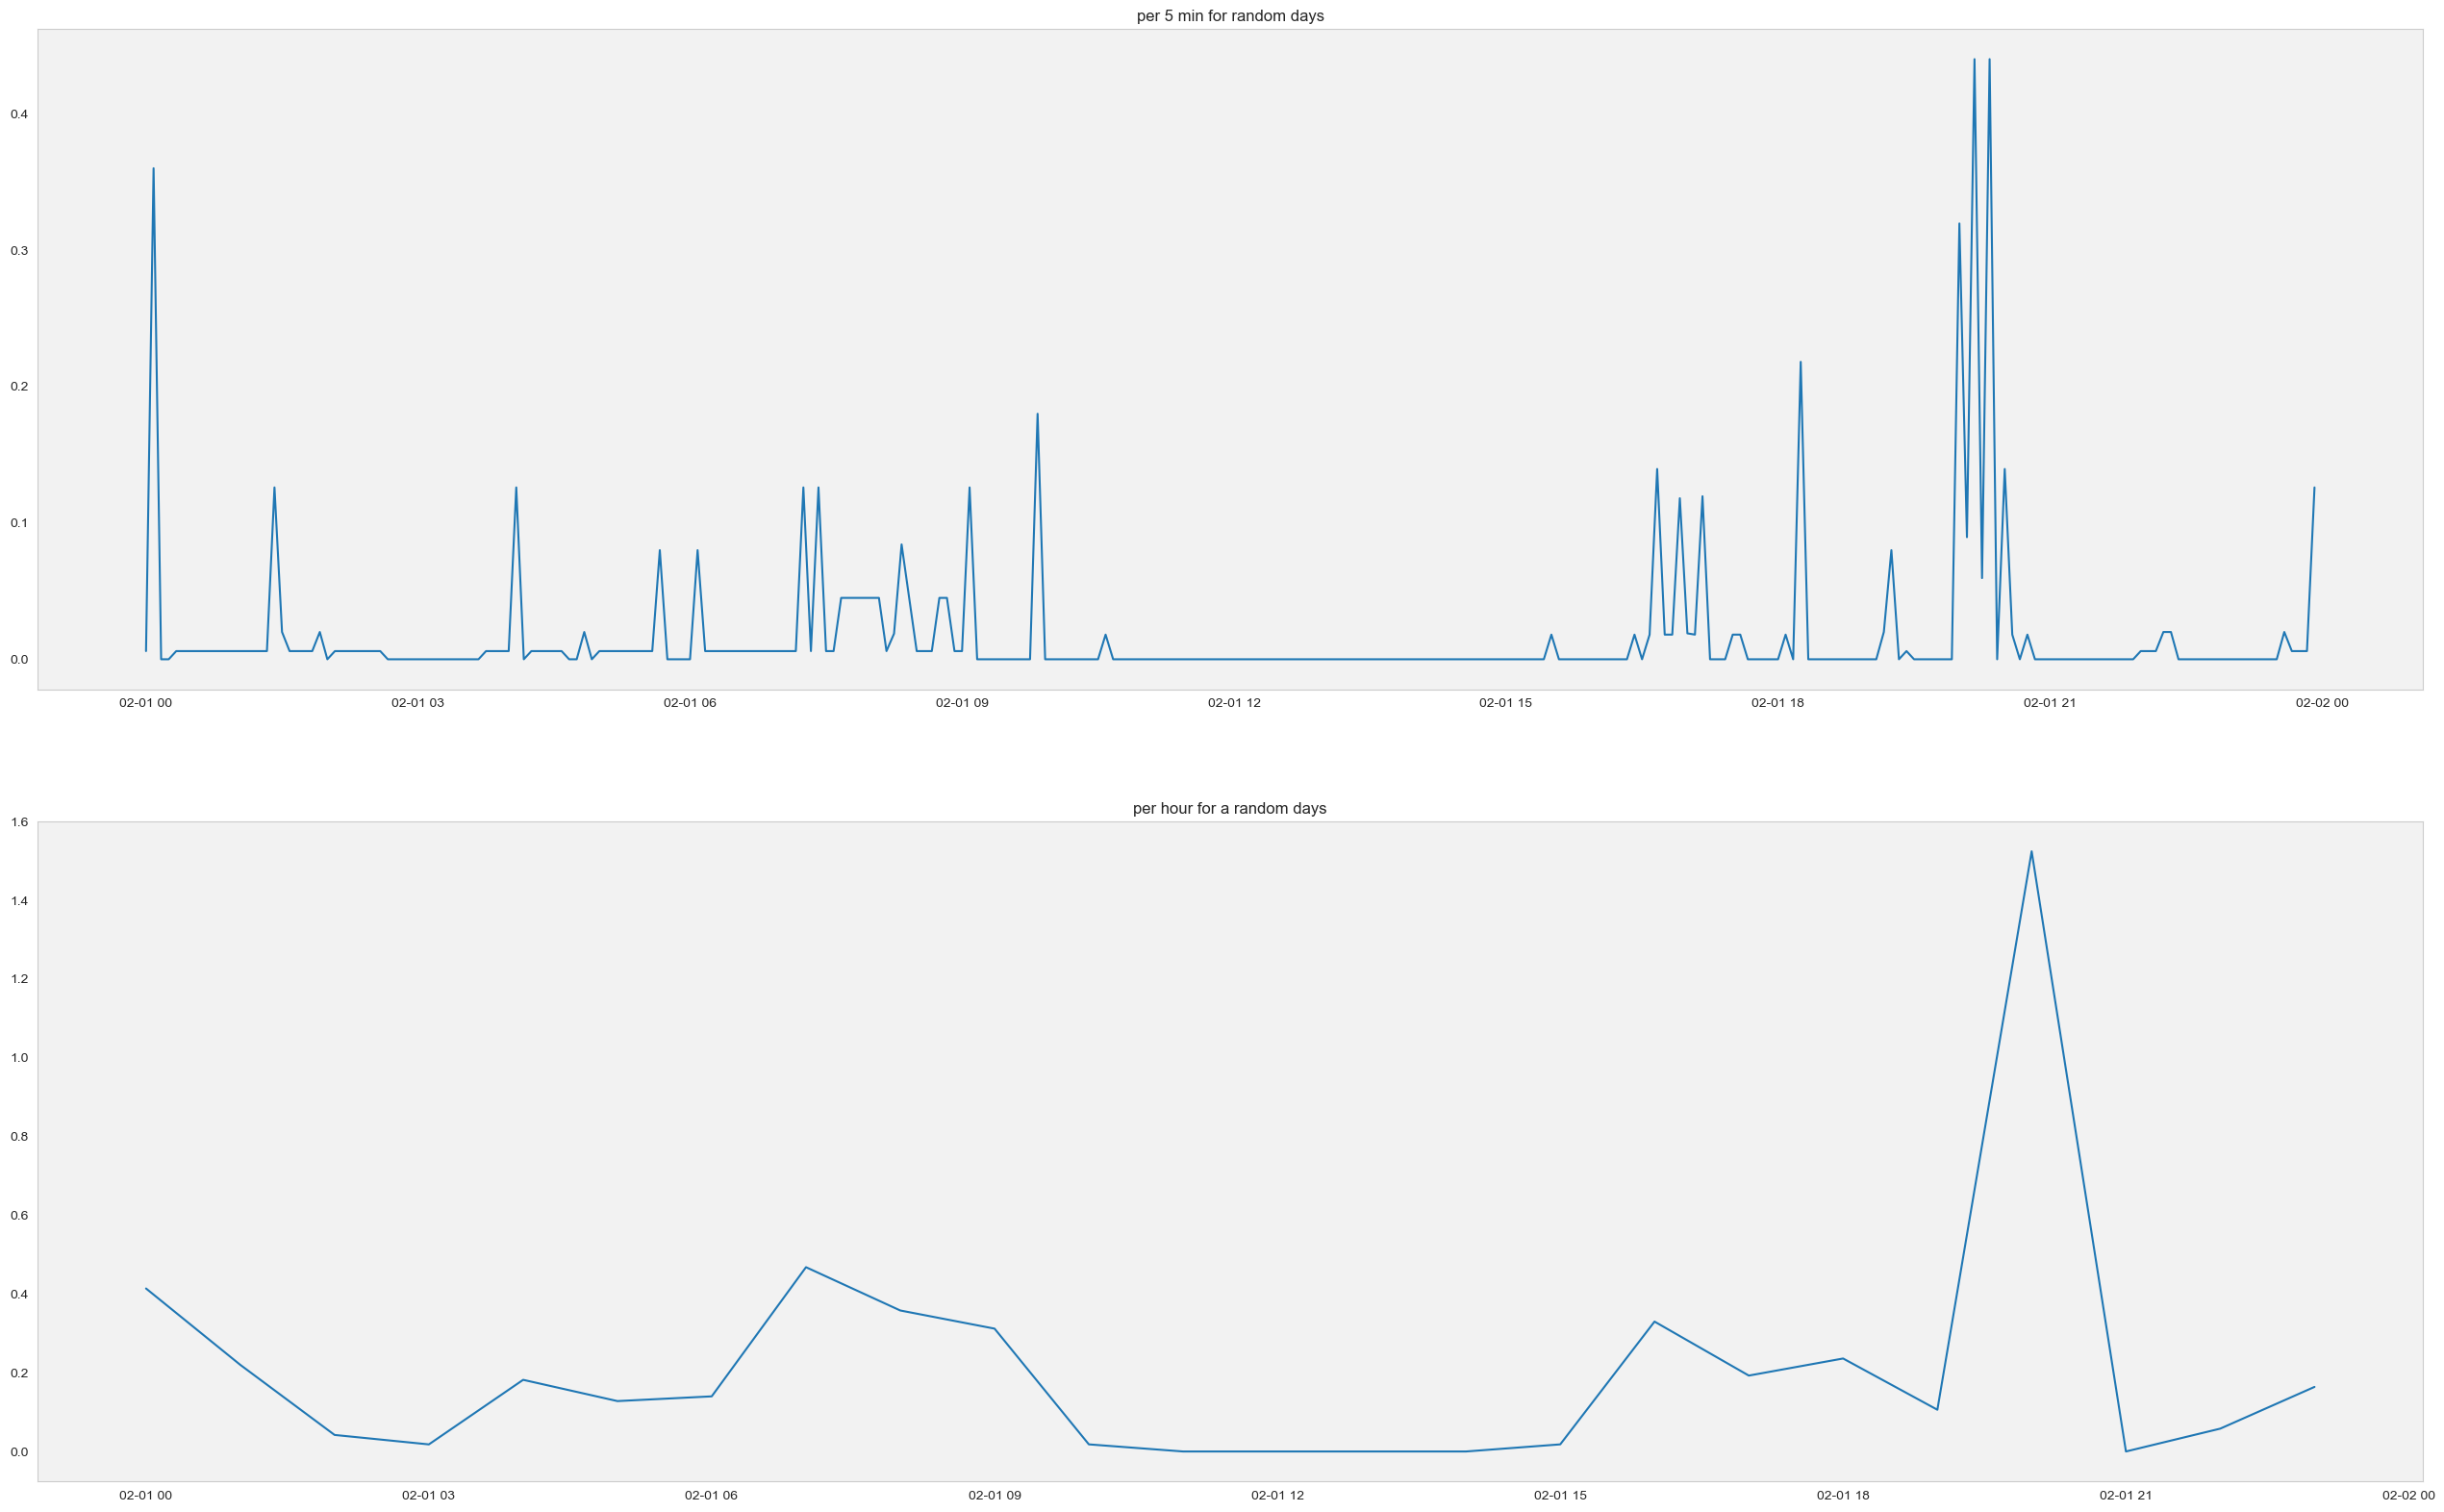

In [14]:
fig, ax = plt.subplots(figsize=(32,20))

plt.subplot(2, 1, 1)
plt.plot(data_per_5min.loc['2015-02-01']['label'])
#plt.plot(data_per_5min['occupancy'])
#plt.plot(data_per_H.loc['2019-05-01':'2019-05-07',:])
plt.title('per 5 min for random days')


plt.subplot(2, 1, 2)
plt.plot(data_per_Hour['2015-02-01']['label'])
#plt.plot(data_per_D.loc['2019-05',:])
plt.title('per hour for a random days')



plt.show()
fig.tight_layout()

In [15]:
# fig = plt.figure(figsize=(20, 15))
# ax1 = fig.add_subplot(211)
# sns.boxplot(data=data, x='month', y='label', ax=ax1)
# ax2 = fig.add_subplot(212)
# sns.boxplot(data=data, x='weekday', y='label', ax=ax2)
# # ax3 = fig.add_subplot(313)
# # sns.boxplot(data=df, x='holiday', y='label', ax=ax3)
# plt.show()

In [16]:
data = data_per_Hour[:]

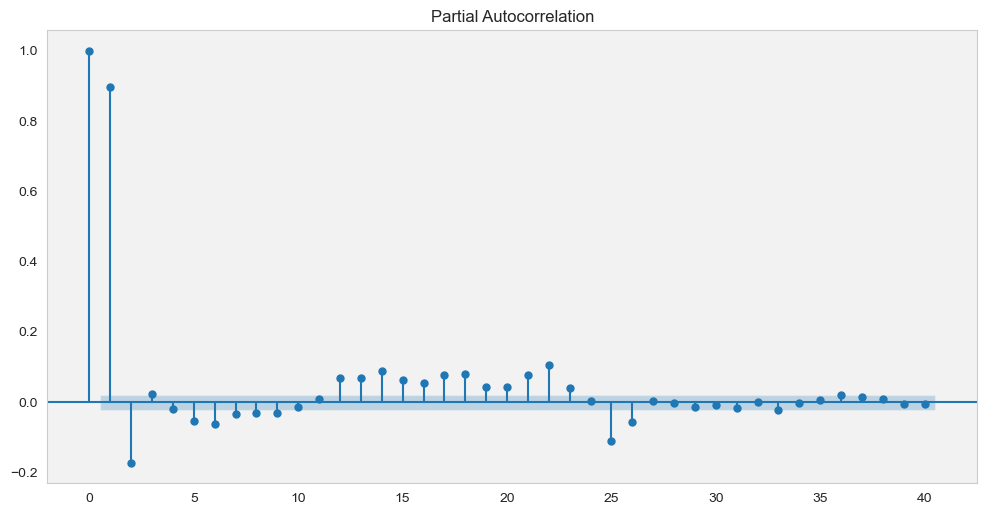

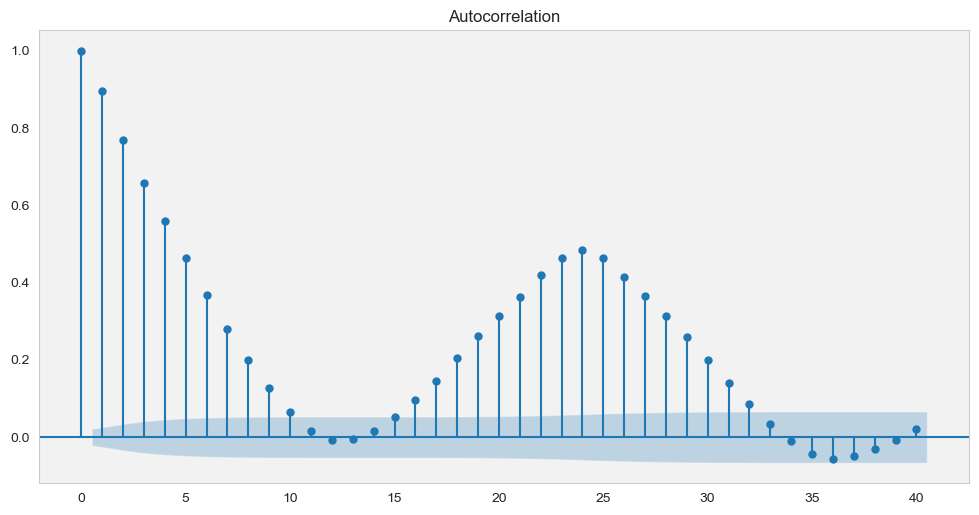

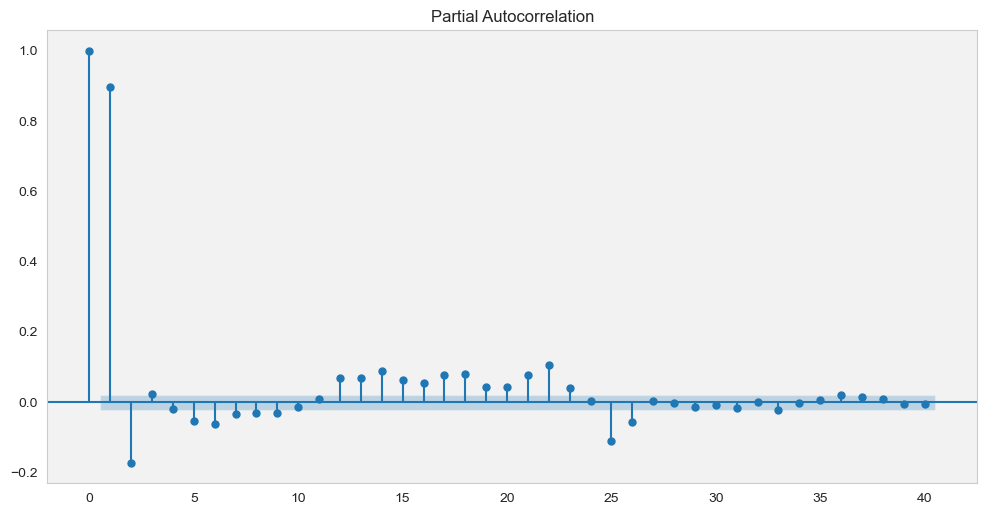

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['label'])
plot_pacf(data['label'])

In [18]:
data.head()

,label
time,
2015-01-06 15:00:00,3.269733
2015-01-06 16:00:00,21.968880
2015-01-06 17:00:00,22.115866
2015-01-06 18:00:00,31.237733
2015-01-06 19:00:00,32.699347


# add simple cal features

In [19]:
import holidays

def add_time_features(df):
    cet_index = df.index
    df["month"] = cet_index.month
    df["weekday"] = cet_index.weekday
    df["hour"] = cet_index.hour
    #df["year"] = cet_index.year
    return df

def add_holiday_features(df):
    de_holidays = holidays.France()
    cet_dates = pd.Series(df.index, index=df.index)
    df["holiday"] = cet_dates.apply(lambda d: d in de_holidays)
    df["holiday"] = df["holiday"].astype(int)
    return df


def add_all_features(df, target_col="conso_global"):
    df = df.copy()
    df = add_time_features(df)
    #df = add_holiday_features(df)
    return df

In [20]:
data = add_all_features(data)

In [21]:
data.head()

,label,month,weekday,hour
time,,,,
2015-01-06 15:00:00,3.269733,1,1,15
2015-01-06 16:00:00,21.968880,1,1,16
2015-01-06 17:00:00,22.115866,1,1,17
2015-01-06 18:00:00,31.237733,1,1,18
2015-01-06 19:00:00,32.699347,1,1,19


## Importing the calendar

In [22]:
from icalendar import Calendar, Event
from datetime import datetime

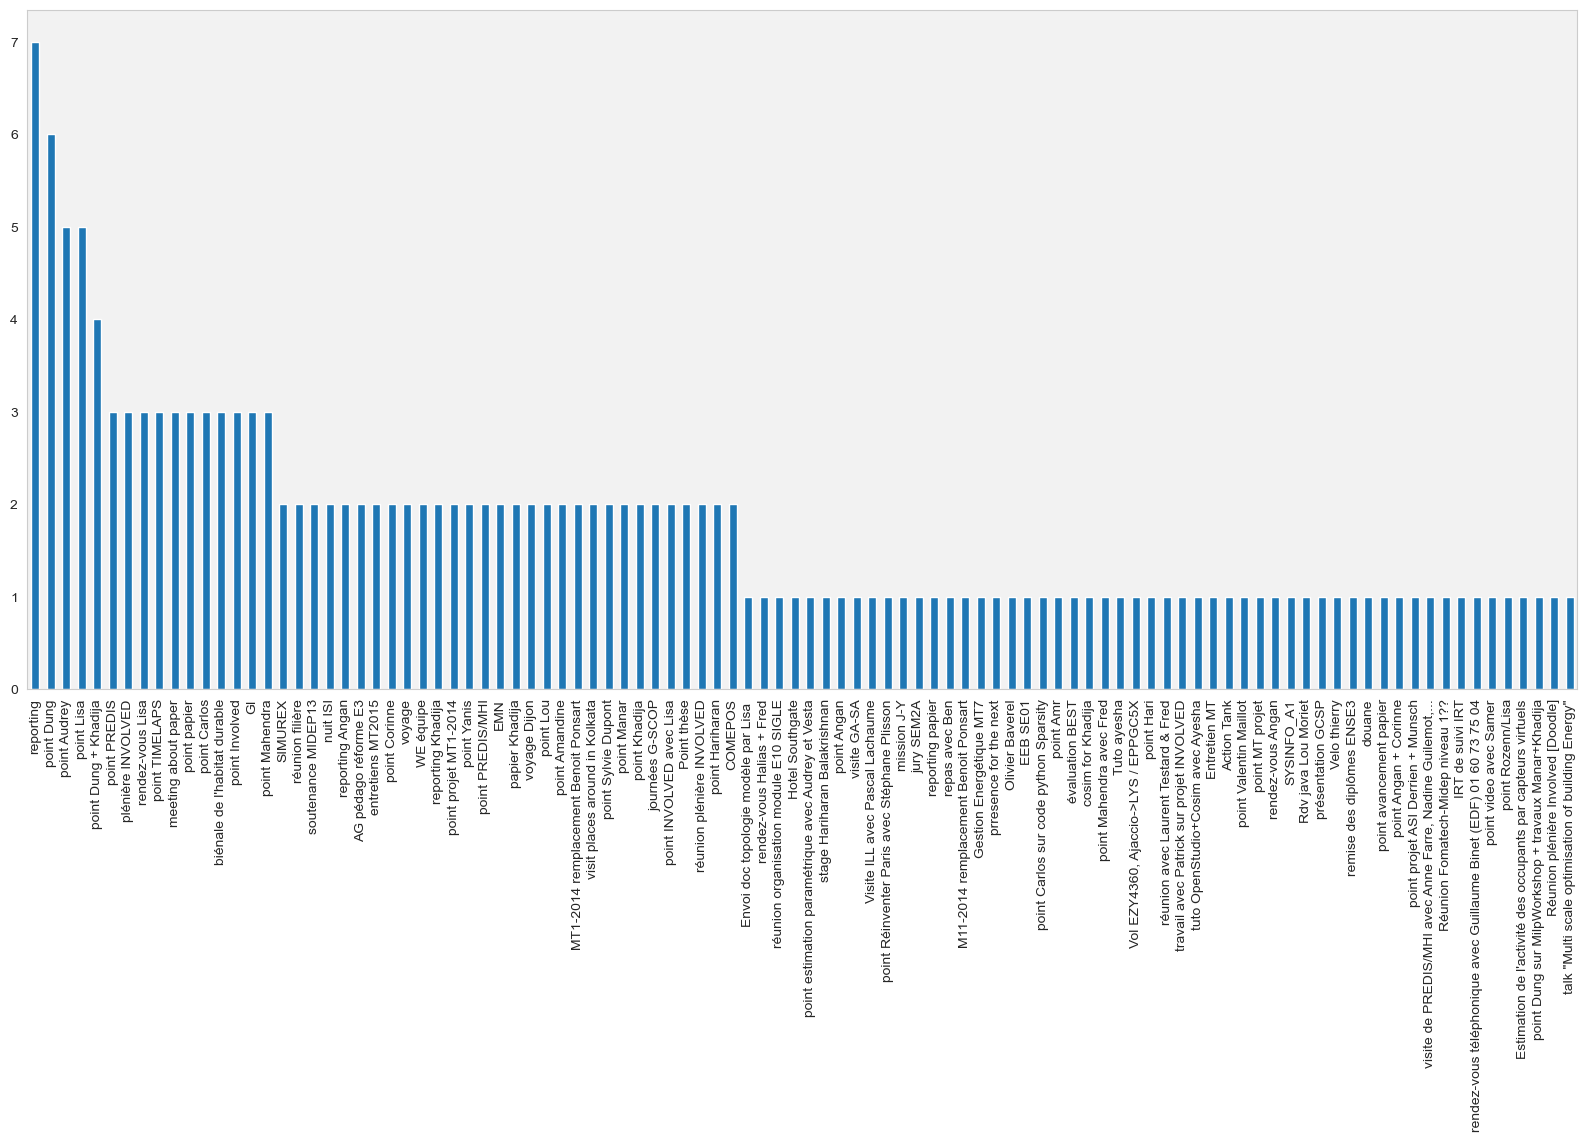

                                         evenement               debut  \
debut                                                                    
2015-01-05 09:15:00                          POO13 2015-01-05 09:15:00   
2015-01-05 15:00:00        point Murielle sur DPEA 2015-01-05 15:00:00   
2015-01-06 13:00:00                réunion mission 2015-01-06 13:00:00   
2015-01-07 07:30:00              Rdv projet Ayesha 2015-01-07 07:30:00   
2015-01-07 08:30:00  appeler amandine pour facture 2015-01-07 08:30:00   

                                           fin  label  
debut                                                  
2015-01-05 09:15:00  2015-01-05 11:15:00+00:00      1  
2015-01-05 15:00:00  2015-01-05 16:00:00+00:00      2  
2015-01-06 13:00:00  2015-01-06 14:30:00+00:00      1  
2015-01-07 07:30:00  2015-01-07 08:30:00+00:00      1  
2015-01-07 08:30:00  2015-01-07 08:45:00+00:00      1  
Empty DataFrame
Columns: [evenement, debut, fin, label]
Index: []
fin test


In [23]:
evenement = []
debut = []
fin =[]


g = open('stephane_stephane.ploix@gmail.com.ics','rb')
gcal = Calendar.from_ical(g.read().decode())
for component in gcal.walk():
    if component.name == "VEVENT":

        evenement.append(str((component.get('summary'))))
        if len(str(component.get('dtstart').dt)) >12:
            debut.append(datetime.strptime(str(component.get('dtstart').dt)[:-6],'%Y-%m-%d %H:%M:%S'))
        else:
            debut.append(datetime.strptime(str(component.get('dtstart').dt), '%Y-%m-%d'))
        if component.get('dtend') is not None:
            fin.append(component.get('dtend').dt)
        else:
            fin.append("Nan")

g.close()

calendrier = pd.DataFrame({'evenement': evenement,'debut':debut,'fin':fin})
calendrier['debut'] =pd.to_datetime(calendrier.debut)
calendrier.sort_values(['debut'], inplace=True)
calendrier = calendrier.set_index(calendrier['debut'])
calendrier = calendrier['2015-01-04':'2015-12-31']


plt.figure(figsize=(20,9))
calendrier.evenement.value_counts()[0:100].plot.bar()
plt.show()

label = []
for k in calendrier.index:
    if "point" in calendrier['evenement'].loc[str(k)]:
        label.append(2)
    else:
        label.append(1)

calendrier['label']=label
print(calendrier.head())



cal = []
nom = []
for k in data['label']:
    cal.append(0)
    nom.append("None")

data['calendrier'] = cal
data['nom']=nom

calendrier.drop_duplicates(subset ="debut",
                     keep = False, inplace = True)
print(calendrier[calendrier.index.duplicated()])
print("fin test")

for k in calendrier.index:
    if k in data.index:
        data['calendrier'].loc[str(k)] = calendrier['label'].loc[str(k)]
        data['nom'].loc[str(k)] = calendrier['evenement'].loc[str(k)]

# plt.figure(figsize=(20,9))
# data['label'].plot()
# data['calendrier'].plot()
# plt.show()

In [24]:
data.head()

,label,month,weekday,hour,calendrier,nom
time,,,,,,
2015-01-06 15:00:00,3.269733,1,1,15,0,None
2015-01-06 16:00:00,21.968880,1,1,16,0,None
2015-01-06 17:00:00,22.115866,1,1,17,0,None
2015-01-06 18:00:00,31.237733,1,1,18,0,None
2015-01-06 19:00:00,32.699347,1,1,19,0,None


In [25]:
data.drop(['nom'], axis =1, inplace=True)

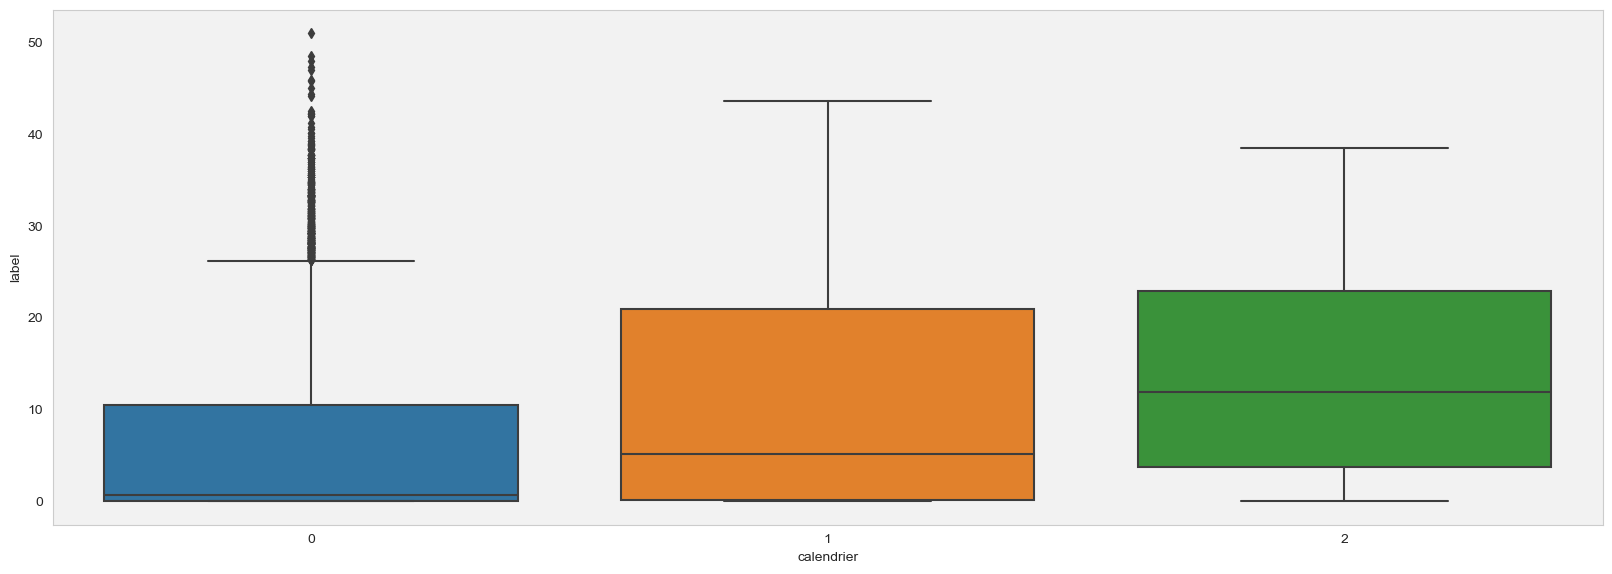

In [26]:
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(211)
sns.boxplot(data=data, x='calendrier', y='label', ax=ax1)
plt.show()

In [27]:
import numpy as np 
np.arange(1)

array([0])

# window 1h: 

In [28]:
# LEADS
leads = np.arange(1)

hour_leads = [f"hour_lead_{lead+1}" for lead in leads ]
weekday_leads = [f"weekday_lead_{lead+1}" for lead in leads ]
month_leads = [f"month_lead_{lead+1}" for lead in leads ]
cal_leads = [f"cal_lead_{lead+1}" for lead in leads ]


for lead, lead_H in zip(leads, hour_leads):
    data[lead_H] = data["hour"].shift(-(lead+1))
    
for lead, lead_W in zip(leads, weekday_leads):
    data[lead_W] = data["weekday"].shift(-(lead+1))
    
for lead, lead_M in zip(leads, month_leads):
    data[lead_M] = data["month"].shift(-(lead+1))
    
for lead, lead_C in zip(leads, cal_leads):
    data[lead_C] = data["calendrier"].shift(-(lead+1))    
    


In [29]:
#LAGS
lags = np.arange(1,25)
lag_cols = [f"label_lag_{lag}" for lag in lags ]
for lag, lag_col in zip(lags, lag_cols):
    data[lag_col] = data["label"].shift(lag)
    
hour_lags = [f"hour_lag_{lag}" for lag in lags ]
weekday_lags = [f"weekday_lag_{lag}" for lag in lags ]
month_lags = [f"month_lag_{lag}" for lag in lags ]
cal_lags = [f"cal_lag_{lag}" for lag in lags ]


for lag, lag_H in zip(lags, hour_lags):
    data[lag_H] = data["hour"].shift(lag)
    
for lag, lag_W in zip(lags, weekday_lags):
    data[lag_W] = data["weekday"].shift(lag)
    
for lag, lag_M in zip(lags, month_lags):
    data[lag_M] = data["month"].shift(lag)

for lag, lag_C in zip(lags, cal_lags):
    data[lag_C] = data["calendrier"].shift(lag)
    


        

In [30]:
#Rolling 

wins = [3, 6, 12, 24, 36, 48]
for win in wins:
    for lag,lag_col in zip(lags, lag_cols):
        data[f"rmean_{lag}_{win}"] = data[lag_col].transform(lambda x : x.rolling(win).mean())
#         data[f"rmax_{lag}_{win}"] = data["label"].shift(lag).transform(lambda x : x.rolling(win).max())
#         data[f"rmin_{lag}_{win}"] = data["label"].shift(lag).transform(lambda x : x.rolling(win).min())
        data[f"rstd_{lag}_{win}"] = data[lag_col].transform(lambda x : x.rolling(win).std())

In [31]:
data.drop(["label_lag_1", "label_lag_2"], axis =1, inplace=True)

,label,month,weekday,hour,calendrier,hour_lead_1,weekday_lead_1,month_lead_1,cal_lead_1,label_lag_3,...,rmean_20_48,rstd_20_48,rmean_21_48,rstd_21_48,rmean_22_48,rstd_22_48,rmean_23_48,rstd_23_48,rmean_24_48,rstd_24_48
time,,,,,,,,,,,,,,,,,,,,,
2015-01-06 15:00:00,3.269733,1,1,15,0,16.0,1.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06 16:00:00,21.968880,1,1,16,0,17.0,1.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06 17:00:00,22.115866,1,1,17,0,18.0,1.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06 18:00:00,31.237733,1,1,18,0,19.0,1.0,1.0,0.0,3.269733,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06 19:00:00,32.699347,1,1,19,0,20.0,1.0,1.0,0.0,21.968880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-29 20:00:00,0.000000,12,1,20,0,21.0,1.0,12.0,0.0,1.500200,...,0.973034,1.388021,1.108784,1.717734,1.244534,1.984182,1.381070,2.210391,1.545229,2.398737
2015-12-29 21:00:00,0.140000,12,1,21,0,22.0,1.0,12.0,0.0,1.502444,...,0.837284,0.930030,0.973034,1.388021,1.108784,1.717734,1.244534,1.984182,1.381070,2.210391
2015-12-29 22:00:00,0.110000,12,1,22,0,23.0,1.0,12.0,0.0,0.119043,...,0.880602,0.988858,0.837284,0.930030,0.973034,1.388021,1.108784,1.717734,1.244534,1.984182


In [32]:
data.rename(columns={"label": "label_lead_0"}, inplace= True)

In [33]:
data.tail()

,label_lead_0,month,weekday,hour,calendrier,hour_lead_1,weekday_lead_1,month_lead_1,cal_lead_1,label_lag_1,...,rmean_20_48,rstd_20_48,rmean_21_48,rstd_21_48,rmean_22_48,rstd_22_48,rmean_23_48,rstd_23_48,rmean_24_48,rstd_24_48
time,,,,,,,,,,,,,,,,,,,,,
2015-12-29 20:00:00,0.00,12,1,20,0,21.0,1.0,12.0,0.0,0.119043,...,0.973034,1.388021,1.108784,1.717734,1.244534,1.984182,1.381070,2.210391,1.545229,2.398737
2015-12-29 21:00:00,0.14,12,1,21,0,22.0,1.0,12.0,0.0,0.000000,...,0.837284,0.930030,0.973034,1.388021,1.108784,1.717734,1.244534,1.984182,1.381070,2.210391
2015-12-29 22:00:00,0.11,12,1,22,0,23.0,1.0,12.0,0.0,0.140000,...,0.880602,0.988858,0.837284,0.930030,0.973034,1.388021,1.108784,1.717734,1.244534,1.984182
2015-12-29 23:00:00,0.12,12,1,23,0,0.0,2.0,12.0,0.0,0.110000,...,0.898954,1.002826,0.880602,0.988858,0.837284,0.930030,0.973034,1.388021,1.108784,1.717734
2015-12-30 00:00:00,0.06,12,2,0,0,NaN,NaN,NaN,NaN,0.120000,...,0.919125,1.016562,0.898954,1.002826,0.880602,0.988858,0.837284,0.930030,0.973034,1.388021


In [34]:
data.dropna(inplace=True)

In [35]:
data.tail()

,label_lead_0,month,weekday,hour,calendrier,hour_lead_1,weekday_lead_1,month_lead_1,cal_lead_1,label_lag_1,...,rmean_20_48,rstd_20_48,rmean_21_48,rstd_21_48,rmean_22_48,rstd_22_48,rmean_23_48,rstd_23_48,rmean_24_48,rstd_24_48
time,,,,,,,,,,,,,,,,,,,,,
2015-12-29 19:00:00,0.119043,12,1,19,0,20.0,1.0,12.0,0.0,1.502444,...,1.108784,1.717734,1.244534,1.984182,1.381070,2.210391,1.545229,2.398737,1.711729,2.561074
2015-12-29 20:00:00,0.000000,12,1,20,0,21.0,1.0,12.0,0.0,0.119043,...,0.973034,1.388021,1.108784,1.717734,1.244534,1.984182,1.381070,2.210391,1.545229,2.398737
2015-12-29 21:00:00,0.140000,12,1,21,0,22.0,1.0,12.0,0.0,0.000000,...,0.837284,0.930030,0.973034,1.388021,1.108784,1.717734,1.244534,1.984182,1.381070,2.210391
2015-12-29 22:00:00,0.110000,12,1,22,0,23.0,1.0,12.0,0.0,0.140000,...,0.880602,0.988858,0.837284,0.930030,0.973034,1.388021,1.108784,1.717734,1.244534,1.984182
2015-12-29 23:00:00,0.120000,12,1,23,0,0.0,2.0,12.0,0.0,0.110000,...,0.898954,1.002826,0.880602,0.988858,0.837284,0.930030,0.973034,1.388021,1.108784,1.717734


In [36]:
#Scaling
scaler = MinMaxScaler()
data['label_lead_0'] = scaler.fit_transform(pd.DataFrame(data['label_lead_0']))
   

lag_cols = [f"label_lag_{lag}" for lag in lags ]
for lag_col in lag_cols:
    data[lag_col] = scaler.transform(pd.DataFrame(data[lag_col]))

    
for win in wins:
    for lag,lag_col in zip(lags, lag_cols):
        data[f"rmean_{lag}_{win}"] = scaler.transform(pd.DataFrame(data[f"rmean_{lag}_{win}"]))
#         data[f"rmax_{lag}_{win}"] = scaler.transform(pd.DataFrame(data[f"rmax_{lag}_{win}"]))
#         data[f"rmin_{lag}_{win}"] = scaler.transform(pd.DataFrame(data[f"rmin_{lag}_{win}"]))
        data[f"rstd_{lag}_{win}"] = scaler.transform(pd.DataFrame(data[f"rstd_{lag}_{win}"]))

In [37]:
data

,label_lead_0,month,weekday,hour,calendrier,hour_lead_1,weekday_lead_1,month_lead_1,cal_lead_1,label_lag_1,...,rmean_20_48,rstd_20_48,rmean_21_48,rstd_21_48,rmean_22_48,rstd_22_48,rmean_23_48,rstd_23_48,rmean_24_48,rstd_24_48
time,,,,,,,,,,,,,,,,,,,,,
2015-01-09 14:00:00,0.434954,1,4,14,0,15.0,4.0,1.0,0.0,0.441565,...,0.113444,0.175761,0.121797,0.189513,0.126066,0.194223,0.134070,0.198741,0.134699,0.198465
2015-01-09 15:00:00,0.571271,1,4,15,0,16.0,4.0,1.0,0.0,0.434954,...,0.102440,0.157617,0.113444,0.175761,0.121797,0.189513,0.126066,0.194223,0.134070,0.198741
2015-01-09 16:00:00,0.739355,1,4,16,0,17.0,4.0,1.0,2.0,0.571271,...,0.091200,0.143402,0.102440,0.157617,0.113444,0.175761,0.121797,0.189513,0.126066,0.194223
2015-01-09 17:00:00,0.726841,1,4,17,2,18.0,4.0,1.0,0.0,0.739355,...,0.081459,0.132753,0.091200,0.143402,0.102440,0.157617,0.113444,0.175761,0.121797,0.189513
2015-01-09 18:00:00,0.413831,1,4,18,0,19.0,4.0,1.0,0.0,0.726841,...,0.075067,0.128987,0.081459,0.132753,0.091200,0.143402,0.102440,0.157617,0.113444,0.175761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-29 19:00:00,0.002334,12,1,19,0,20.0,1.0,12.0,0.0,0.029460,...,0.021741,0.033681,0.024403,0.038906,0.027080,0.043341,0.030299,0.047034,0.033563,0.050217
2015-12-29 20:00:00,0.000000,12,1,20,0,21.0,1.0,12.0,0.0,0.002334,...,0.019079,0.027216,0.021741,0.033681,0.024403,0.038906,0.027080,0.043341,0.030299,0.047034
2015-12-29 21:00:00,0.002745,12,1,21,0,22.0,1.0,12.0,0.0,0.000000,...,0.016417,0.018236,0.019079,0.027216,0.021741,0.033681,0.024403,0.038906,0.027080,0.043341


In [ ]:
8506  *0.75

In [38]:
train_data = data.iloc[0:6380]
test_data = data.iloc[6380:]

train_data.shape, test_data.shape

((6380, 417), (2126, 417))

In [39]:
lead_cols = ['label_lead_0']

In [40]:
x_train_data = train_data.drop(lead_cols, axis=1)
y_train_data = train_data.loc[:, lead_cols]
x_test_data = test_data.drop(lead_cols, axis=1)
y_test_data = test_data.loc[:, lead_cols]

In [41]:
y_train_data

,label_lead_0
time,
2015-01-09 14:00:00,0.434954
2015-01-09 15:00:00,0.571271
2015-01-09 16:00:00,0.739355
2015-01-09 17:00:00,0.726841
2015-01-09 18:00:00,0.413831
...,...
2015-10-02 05:00:00,0.000000
2015-10-02 06:00:00,0.004817
2015-10-02 07:00:00,0.000321


In [42]:
import lightgbm as lgbm
from sklearn import metrics
from sklearn import model_selection

In [43]:
threshold = -2
features = []
for col in y_train_data.columns:
    correlation = pd.DataFrame(train_data.drop(lead_cols, axis=1).corrwith(train_data[col]), columns=['corr'])
    thresh_corr = correlation[correlation['corr']> threshold]
    features.append(list(thresh_corr.index))

In [44]:
pd.DataFrame(features)

,0,1,2,3,4,5,6,7,8,9,...,406,407,408,409,410,411,412,413,414,415
0,month,weekday,hour,calendrier,hour_lead_1,weekday_lead_1,month_lead_1,cal_lead_1,label_lag_1,label_lag_2,...,rmean_20_48,rstd_20_48,rmean_21_48,rstd_21_48,rmean_22_48,rstd_22_48,rmean_23_48,rstd_23_48,rmean_24_48,rstd_24_48


In [45]:
from tqdm import tqdm

result = pd.DataFrame()
models = dict()
for counter, col in enumerate(tqdm(y_train_data.columns)):
    
    result[f'pred_{counter}'] = np.zeros(y_test_data.shape[0])
    
    used_features = features[counter]
    
    x_train_local = x_train_data.loc[:, used_features]
    y_train_local = y_train_data.loc[:, col]
    x_test_local = x_test_data.loc[:, used_features]
    y_test_local = y_test_data.loc[:, col]
    
    
    model = lgbm.LGBMRegressor(
        objective='regression',
        max_depth=5,
        num_leaves=5 ** 2 - 1,
        learning_rate=0.007,
        n_estimators=30000,
        min_child_samples=80,
        subsample=0.8,
        colsample_bytree=1,
        reg_alpha=0,
        reg_lambda=0,
        random_state=np.random.randint(10e6)
    )

    n_splits = 6
    cv = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=42)

    val_scores = [0] * n_splits




    #feature_importances = pd.DataFrame(index=x_train_local.columns)

    for i, (fit_idx, val_idx) in enumerate(cv.split(x_train_local, y_train_local)):

        X_fit = x_train_local.iloc[fit_idx]
        y_fit = y_train_local.iloc[fit_idx]
        X_val = x_train_local.iloc[val_idx]
        y_val = y_train_local.iloc[val_idx]

        model.fit(
            X_fit,
            y_fit,
            eval_set=[(X_fit, y_fit), (X_val, y_val)],
            eval_names=('fit', 'val'),
            eval_metric='l2',
            early_stopping_rounds=200,
            feature_name=X_fit.columns.tolist(),
            verbose=False
        )

        val_scores[i] = np.sqrt(model.best_score_['val']['l2'])
        result[f'pred_{counter}'] += model.predict(x_test_local, num_iteration=model.best_iteration_)
        #feature_importances[i] = model.feature_importances_

        print('Fold {} RMSLE: {:.5f}'.format(i+1, val_scores[i]))

    result[f'pred_{counter}'] /= n_splits
    result[f'pred_{counter}'] = np.expm1(result[f'pred_{counter}'])

    val_mean = np.mean(val_scores)
    val_std = np.std(val_scores)

    print('Local RMSLE: {:.5f} (±{:.5f})'.format(val_mean, val_std))
    models[col] = model

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Fold 1 RMSLE: 0.07280
Fold 2 RMSLE: 0.07129
Fold 3 RMSLE: 0.06597
Fold 4 RMSLE: 0.07343
Fold 5 RMSLE: 0.07499


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.13s/it]

Fold 6 RMSLE: 0.07066
Local RMSLE: 0.07152 (±0.00286)


In [46]:
result

,pred_0
0,0.102427
1,0.258537
2,0.412908
3,0.732912
4,0.790331
...,...
2121,0.036385
2122,0.004509
2123,0.002356
2124,0.005340


In [47]:
final_test = y_test_data.values.flatten()
final_resut = result.values.flatten()

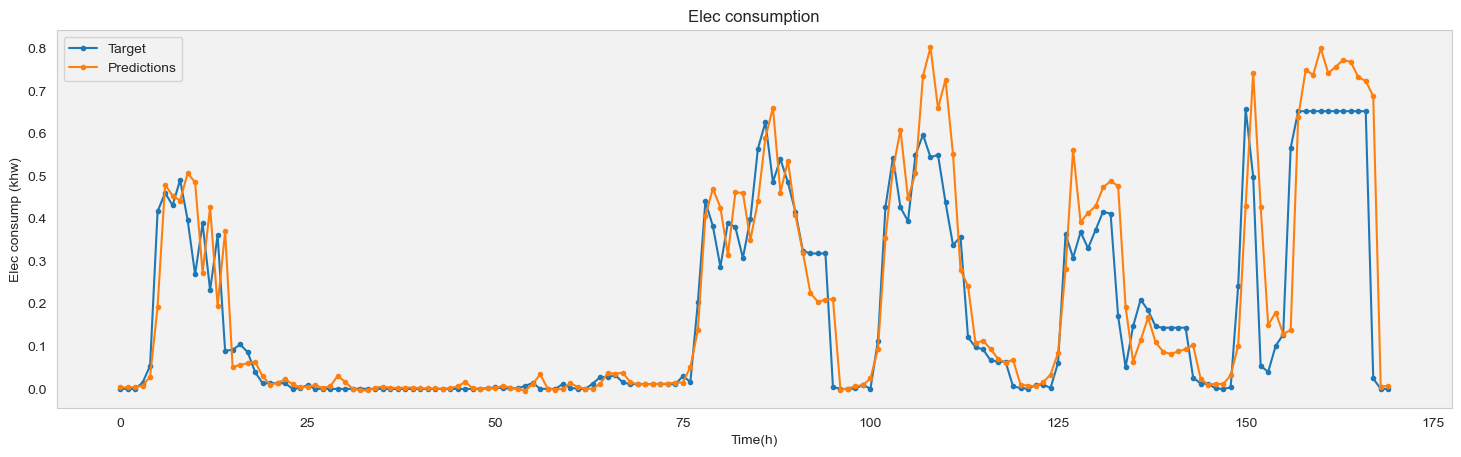

In [48]:
plt.figure(figsize=(18,5))

plt.plot(final_test[330:500], marker='.',label='Target')
plt.plot(final_resut[330:500], marker='.', label='Predictions')
plt.title('Elec consumption')
plt.xlabel('Time(h)')
plt.ylabel('Elec consump (khw)')
plt.legend()
plt.show()

In [49]:
print( "The RMSE for Stacked LSTM model is: %f" %np.sqrt(mean_squared_error(final_test,final_resut)))
print( "The accuracy of Stacked LSTM model is: %f" %r2_score(final_test,final_resut))

The RMSE for Stacked LSTM model is: 0.090096
The accuracy of Stacked LSTM model is: 0.807212
